# ODYM Example no. 1.  System with two processes, two parameters, one material.

A simple MFA system with one material (represented by the indicator element carbon 'C'), a time horizon of 30 years [1980-2010], two processes, and a time-dependent parameter is analysed.

<img src="Images/MFAExample1.png" width="404" height="490" alt="Simple MFA system">


The model equations are as follows:
+ $a(t) = D(t)$ (exogenous input flow)
+ $d(t) = \alpha (t)\cdot b(t)$ (recovery efficiency parameter)
+ $a(t) +d(t) = d(t) $ (mass balance process 1)
+ $b(t) = c(t) + d(t) $ (mass balance process 2)

From these equations the system solution follows:
+ $c(t) = a(t) = D(t)$
+ $b(t) = \frac{1}{1-\alpha (t)}\cdot D(t)$
+ $c(t) = \frac{\alpha}{1-\alpha (t)}\cdot D(t)$

We will now programm this solution into ODYM. That is overkill, as ODYM was developed for handling much more complex MFA systems, but instructive.


### 1) Load ODYM


In [1]:
# Load a local copy of the current ODYM branch:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# For Ipython Notebook only
%matplotlib inline

sys.path.insert(0, os.path.join('..', 'odym', 'modules')) # add ODYM module directory to system path, relative
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'odym', 'modules')) # add ODYM module directory to system path, absolute
import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

### 2) Define MFA system 
With the model imported, we cannow set up the system definition. The 'classical' elements of the system definition in MFA include: The processes, flows, and stocks, the material, the region, and the time frame studied. Next to these elements, ODYM features/requires the following elements to be specified:
+ The list of chemical elements considered
+ The classification(s) of the system variables (stocks and flows): Which materials, products, regions, or waste groups are considered?
+ An index letter to quickly/directly access a model aspect.
+ A dictionary of model parameters

For all these items ODYM has a specific structure, which is used below.

First, we define a classification of all objects flowing. In this example we conduct a 'classical' dynamic MFA with just one material/chemical element/indicator element considered, and our classification can therefore be as simple as possible: it contains only one chemical element, in this case, we choose carbon ('C'):

In [2]:
ModelClassification  = {} # Create dictionary of model classifications

ModelClassification['Time'] = msc.Classification(Name = 'Time', Dimension = 'Time', ID = 1, 
                                                 Items = list(np.arange(1980,2011)))

# Classification for time labelled 'Time' must always be present, 
# with Items containing a list of odered integers representing years, months, or other discrete time intervals

ModelClassification['Element'] = msc.Classification(Name = 'Elements', Dimension = 'Element', ID = 2, 
                                                    Items = ['C'])

# Classification for elements labelled 'Element' must always be present, 
# with Items containing a list of the symbols of the elements covered.

# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

That dictionary of classifications enteres the index table defined for the system. The indext table lists all aspects needed and assigns a classification and index letter to each aspect.

In [3]:
IndexTable = pd.DataFrame({'Aspect'        : ['Time','Element'], # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect "time"', 'Model aspect "Element"'],
                           'Dimension'     : ['Time','Element'], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification[Aspect] for Aspect in ['Time','Element']],
                           'IndexLetter'   : ['t','e']}) # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace = True) 

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e


We can now define our MFA system: 

In [4]:
Dyn_MFA_System = msc.MFAsystem(Name = 'TestSystem', 
                      Geogr_Scope = 'TestRegion', 
                      Unit = 'Mt', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = {}, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) # Initialize MFA system

This system has a name, a geographical scope, a system-wide unit, a time frame, an index table with all aspects defined, and a list of chemical elements considered.

### 3) Inserting data into the MFA system

It is lacking a list of processes, stocks, flows, and parameters, and these are now defined and inserted into the system:

In [5]:
Dyn_MFA_System.ProcessList = [] # Start with empty process list, only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Environment', ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Process 1'  , ID   = 1))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Process 2'  , ID   = 2))

# Print list of processes:
Dyn_MFA_System.ProcessList

In [6]:
ParameterDict = {}

# Define parameter Inflow (D) with indices 'te' (years x element) and matching time series Values (array with size 31 x 1).
# In a more advanced setup the parameters are defined in a data template and then read into the software.
ParameterDict['D']  = msc.Parameter(Name = 'Inflow',        ID = 1, P_Res = 1, MetaData = None, Indices = 'te', Values= np.arange(0,31).reshape(31,1), Unit = 'Mt/yr')

# Define parameter Recovery rate (alpha) with indices 'te' (years x element) and matching time series Values(array with size 31 x 1).
# In a more advanced setup the parameters are defined in a data template and then read into the software.
ParameterDict['alpha'] = msc.Parameter(Name = 'Recovery rate', ID = 2, P_Res = 2, MetaData = None, Indices = 'te', Values= np.arange(2,33).reshape(31,1)/34, Unit = '1')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

In [7]:
# Define the four flows a,b,c,d of the system, and initialise their values:
Dyn_MFA_System.FlowDict['a'] = msc.Flow(Name = 'Input'              , P_Start = 0, P_End = 1, Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['b'] = msc.Flow(Name = 'Consumption'        , P_Start = 1, P_End = 2, Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['c'] = msc.Flow(Name = 'Output'             , P_Start = 2, P_End = 0, Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['d'] = msc.Flow(Name = 'Recovered material' , P_Start = 2, P_End = 1, Indices = 't,e', Values=None)

# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_FlowValues() 

In [8]:
# Check whether flow value arrays match their indices, etc. See method documentation.
Dyn_MFA_System.Consistency_Check() 

(True, True, True)

### 4) Programming a solution of the MFA system
Now the system definition is complete, and we can program the model solution:

In [9]:
Dyn_MFA_System.FlowDict['a'].Values = Dyn_MFA_System.ParameterDict['D'].Values
Dyn_MFA_System.FlowDict['b'].Values = 1 / (1 - Dyn_MFA_System.ParameterDict['alpha'].Values) * \
    Dyn_MFA_System.ParameterDict['D'].Values
Dyn_MFA_System.FlowDict['c'].Values = Dyn_MFA_System.ParameterDict['D'].Values
Dyn_MFA_System.FlowDict['d'].Values = Dyn_MFA_System.ParameterDict['alpha'].Values / \
    (1 - Dyn_MFA_System.ParameterDict['alpha'].Values) * Dyn_MFA_System.ParameterDict['D'].Values

### 5) Mass-balance-check, analyse, and store the model solution
One major advantage of the ODYM system structure is that mass balance checks can be performed automatically using unit-tested routines without further programming need:

In [10]:
Bal = Dyn_MFA_System.MassBalance()
print(Bal.shape) # dimensions of balance are: time step x process x chemical element
print(np.abs(Bal).sum()) # reports the sum of all absolute balancing errors.

(31, 3, 1)
1.0044742815296104e-13


The ODYM mass balance array reports the balance for each chemical element, each year, and each process, including the system balance (process 0).

Text(0, 0.5, 'Flow a in Mt/yr')

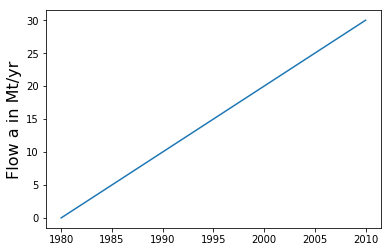

In [11]:
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, Dyn_MFA_System.FlowDict['a'].Values)
ax.set_ylabel('Flow a in Mt/yr', fontsize =16)

Text(0, 0.5, 'Flow b in Mt/yr')

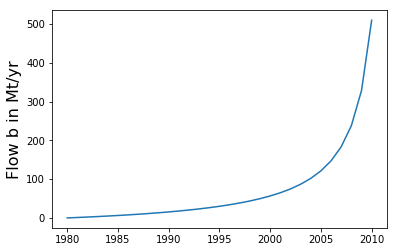

In [12]:
fig, ax = plt.subplots()
ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, Dyn_MFA_System.FlowDict['b'].Values)
ax.set_ylabel('Flow b in Mt/yr', fontsize =16)

Save entire system: 

In [13]:
pickle.dump({'MFATestSystem': Dyn_MFA_System}, open("Tutorial1_MFATestSystem.p", "wb") )